In [1]:
!git clone --depth 1 -b v2.7.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 1345, done.
remote: Counting objects: 100% (1345/1345), done.
remote: Compressing objects: 100% (1128/1128), done.
remote: Total 1345 (delta 363), reused 452 (delta 196), pack-reused 0
Receiving objects: 100% (1345/1345), 1.96 MiB | 7.92 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Note: checking out '14918e0246cc0b7601b4cd7307b3e969df718c65'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



Installing requirements to use tensorflow/models repository

In [2]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 7.9 MB 6.5 MB/s 
     |████████████████████████████████| 15.7 MB 33.9 MB/s 
     |████████████████████████████████| 11.3 MB 33.4 MB/s 
     |████████████████████████████████| 296 kB 49.0 MB/s 
     |████████████████████████████████| 99 kB 8.0 MB/s 
     |████████████████████████████████| 38.1 MB 1.6 MB/s 
     |████████████████████████████████| 213 kB 49.7 MB/s 
     |████████████████████████████████| 4.0 MB 38.0 MB/s 
     |████████████████████████████████| 1.1 MB 45.4 MB/s 
     |████████████████████████████████| 352 kB 48.1 MB/s 
     |████████████████████████████████| 1.9 MB 38.6 MB/s 
     |████████████████████████████████| 11.2 MB 35.7 MB/s 
     |████████████████████████████████| 596 kB 50.8 MB/s 
     |████████████████████████████████| 47.7 MB 1.8 MB/s 
     |████████████████████████████████| 3.1 MB 36.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 1.2 MB 40.0 MB/s 
     |██████████

**After installing requirements, restart the runtime. (Ctrl + M)**

Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('/content/models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


Downloading datasets. One with fake news and other one with true news

In [3]:
import pandas as pd

fake_data = pd.read_csv('/content/drive/MyDrive/News/Fake.csv')
true_data = pd.read_csv('/content/drive/MyDrive/News/True.csv') 
true_data.shape, fake_data.shape

((21417, 4), (23481, 4))

Adding labels to the dataset

In [4]:
true_data['real'] = 1
fake_data['real'] = 0

In [5]:
true_data.head()

,title,text,subject,date,real
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [6]:
fake_data.head()

,title,text,subject,date,real
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


Shuffling fake and real news

In [7]:
from sklearn.utils import shuffle

data = pd.concat([true_data, fake_data])

# Shuffle the data
data = shuffle(data).reset_index(drop=True)

In [8]:
data.head(10)

,title,text,subject,date,real
0,Trump's team seeks top-secret clearance for hi...,WASHINGTON (Reuters) - Republican President-el...,politicsNews,"November 14, 2016",1
1,Greece overcomes forestry setback to develop A...,ATHENS (Reuters) - Greece has won an appeal ov...,worldnews,"October 3, 2017",1
2,French Journalist Hit With Huge Fine For “Inci...,Americans should pay close attention to this s...,politics,"Dec 23, 2015",0
3,Senator Delivers SCATHING Rebuke To His GOP C...,"It s been a tragic, but infuriating day for Am...",News,"November 5, 2017",0
4,Donald Trump Sports New Hairdo In Son’s Insta...,If there s one thing that has always remained ...,News,"January 5, 2017",0
5,KEY TRUMP ADVISOR: ELTON JOHN Will Perform At ...,Elton John will perform at Donald Trump s inau...,politics,"Nov 23, 2016",0
6,Palin's endorsement fails to excite Trump rall...,"NORWALK, Iowa (Reuters) - When it comes to inf...",politicsNews,"January 20, 2016",1
7,LOOK WHO Approved Visas For Russian Operatives...,According to Fox News A federal grand jury on...,politics,16-Feb-18,0
8,Saudi-led coalition to allow cranes into Yemen...,DUBAI (Reuters) - The Saudi-led coalition will...,worldnews,"December 20, 2017",1
9,WATCH: PRESIDENT TRUMP CHANNELS Successful Dev...,WASHINGTON President Trump said on Thursday ...,left-news,"Dec 14, 2017",0


Splitting dataset into train, validation and test sets

In [9]:
from sklearn.model_selection import train_test_split

train_data, remaining = train_test_split(data, random_state=42, train_size=0.7, stratify=data.real.values)
valid_data, test_data = train_test_split(remaining, random_state=42, train_size=0.25, stratify=remaining.real.values)
train_data.shape, valid_data.shape, test_data.shape

((31428, 5), (3367, 5), (10103, 5))

Creating dataset consisting only from text and labels with use of TensorFlow methods

In [10]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_data['text'].values, train_data['real'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_data['text'].values, valid_data['real'].values))

  for text, label in train_data.take(10):
    print(text)
    print(label)

tf.Tensor(b'Lefty losers  ', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'The LGBT Mafia and PC Police doing what they do best shaming Americans and businesses into conformity. Does anyone have the courage or fortitude to fight back, or are we just going to allow these PC thugs to strip our children of the genders God clearly assigned to each of us? Target Corp. is removing gender labels from most of its children s departments after customers complained about signs designating certain toys for girls.The kids  bedding section will no longer feature boy and girl signage, and the toy department will be without labels and pink or blue paper on the shelves, Minneapolis-based Target said on its website Friday. Gender labels will remain in the kids  clothing section because of sizing and fit differences.Retailers have been moving away from gender stereotypes, and some startups have emerged to break down the divide in kids  clothing and toys. The signage that sparked

Importing BERT model as a Keras layer with tokenizer and vocabulary file



In [11]:
label_list = [0, 1]  # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32


# Get BERT layer and tokenizer:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

vocab_file

b'/tmp/tfhub_modules/ce53fe6769d2ac3a260e92555120c54e1aecbea6/assets/vocab.txt'

Function to convert row from dataset to input features and label

In [12]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None, text_a=text.numpy(), text_b=None, label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer) 
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

Function to map inputs and output

In [13]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids
  }

  return (x, label_id)

Creating a TensorFlow Input Pipeline

In [14]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  
  # test
  test_data = tf.data.Dataset.from_tensor_slices((test_data['text'].values, test_data['real'].values))
  test_data = (test_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

In [15]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [16]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [17]:
test_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

Creating a model

In [18]:
# Building the model
def create_model():
  
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_type_ids")
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop)

  model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output)
  return model

In [19]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 128, 768)]                'input_mask[0][0]',         

Training a model

In [20]:
epochs = 3
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/3
982/982 [==============================] - 1637s 2s/step - loss: 0.0121 - binary_accuracy: 0.9969 - val_loss: 0.0037 - val_binary_accuracy: 0.9994
Epoch 2/3
982/982 [==============================] - 1606s 2s/step - loss: 0.0020 - binary_accuracy: 0.9996 - val_loss: 0.0029 - val_binary_accuracy: 0.9991
Epoch 3/3
982/982 [==============================] - 1629s 2s/step - loss: 0.0020 - binary_accuracy: 0.9996 - val_loss: 3.7260e-05 - val_binary_accuracy: 1.0000


In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

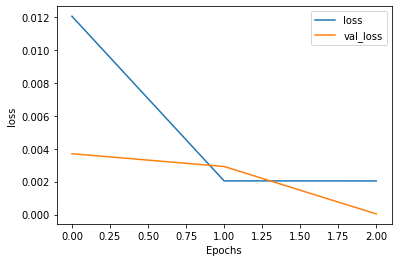

In [22]:
plot_graphs(history, 'loss')

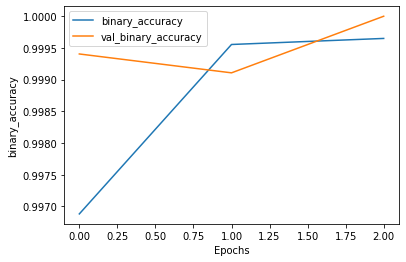

In [23]:
plot_graphs(history, 'binary_accuracy')

In [24]:
predictions = model.predict(test_data)

In [25]:
loss, accuracy = model.evaluate(test_data)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

315/315 [==============================] - 175s 555ms/step - loss: 0.0015 - binary_accuracy: 0.9997
Loss: 0.0015213902806863189
Accuracy: 0.9997023940086365


In [26]:
sample_example = ['This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017"',
                  'As U.S. budget fight looms, Republicans flip their fiscal script,"WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a â€śfiscal conservativeâ€ť on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBSâ€™ â€śFace the Nation,â€ť drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense â€śdiscretionaryâ€ť spending on programs that support education, scientific research, infrastructure, public health and environmental protection. â€śThe (Trump) administration has already been willing to say: â€Weâ€™re going to increase non-defense discretionary spending ... by about 7 percent,â€™â€ť Meadows, chairman of the small but influential House Freedom Caucus, said on the program. â€śNow, Democrats are saying thatâ€™s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I donâ€™t see where the rationale is. ... Eventually you run out of other peopleâ€™s money,â€ť he said. Meadows was among Republicans who voted in late December for their partyâ€™s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. â€śItâ€™s interesting to hear Mark talk about fiscal responsibility,â€ť Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. â€śThis is one of the least ... fiscally responsible bills weâ€™ve ever seen passed in the history of the House of Representatives. I think weâ€™re going to be paying for this for many, many years to come,â€ť Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or â€śentitlement reform,â€ť as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, â€śentitlementâ€ť programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryanâ€™s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the â€śDreamers,â€ť people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. â€śWe need to do DACA clean,â€ť she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid.']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
threshold = 0.5 
['Real' if pred>=threshold else 'Fake' for pred in preds]

['Fake', 'Real']

Saving a model

In [27]:
model.save('/content/drive/MyDrive/News/bert_model', include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/News/bert_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/News/bert_model/assets
